# Disentangled Representational Learning of Single Lead Electrocardiogram Signals using  Variational Autoencoder

### Imports

In [69]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import glob
import ipywidgets as widgets

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.metrics.disentanglement import Disentanglement
from src.utils.helper import Helper
from src.utils.visualizations import Visualizations

### Path Selection

In [70]:
val = widgets.Dropdown(
    options=glob.glob('../results/*'),
    description='Base path:',
    disabled=False,
)

In [71]:
val

Dropdown(description='Base path:', options=('../results/2024-01-14_18-58-13', '../results/2024-01-14_19-13-42'…

In [76]:
base_path = val.value + '/'
path_evaluation = base_path + 'evaluation/'
path_training = base_path + 'training/'

### 0. General

In [77]:
params = Helper.load_yaml_file(base_path + 'params.json')

In [78]:
train_progress = pd.read_csv(path_training + 'training_progress.csv')

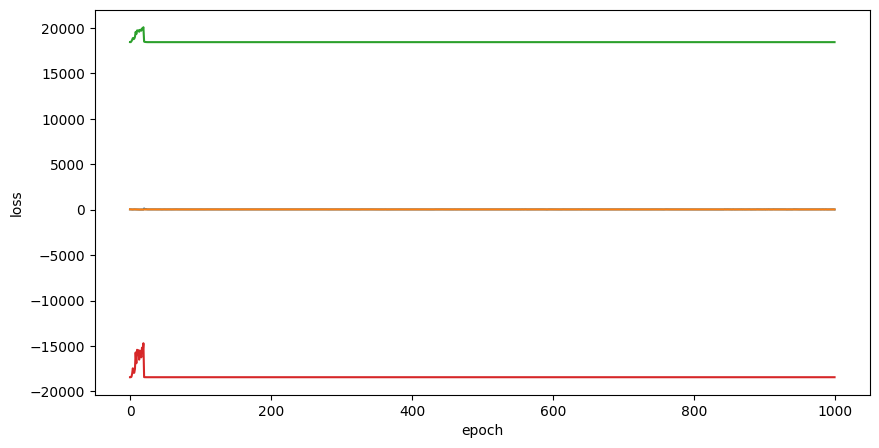

In [79]:
Visualizations.plot_trainings_process(train_progress, ['loss', 'recon', 'mi', 'tc'])

### 1. Disentanglement

In [80]:
df, ld = Helper.load_embedding(path_evaluation, 'synth', 'train')

In [81]:
pca_data = Helper.embedding(df.iloc[:, 0:ld], df.iloc[:, ld:])

/mnt/sdb/home/ml/Desktop/VECG/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


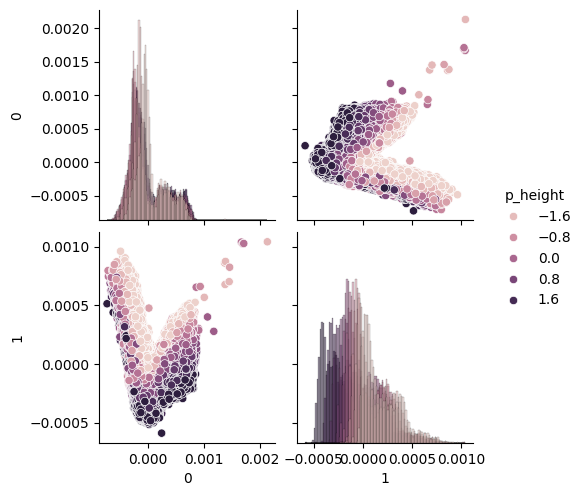

In [85]:
ax = sns.pairplot(pca_data[[0, 1, 'p_height']], hue="p_height", diag_kind="hist")

In [86]:
mus_train = np.array(df.iloc[:, 0:ld])
ys_train = np.array(df.iloc[:, ld:])

In [87]:
Disentanglement.compute_mig(mus_train, ys_train)

{'discrete_mig': 0.009990257009228308}

### 2. Anomaly Detection

In [88]:
df, ld = Helper.load_embedding(path_evaluation, 'zheng', 'train')

In [89]:
a = ['SB', 'SR', 'AFIB', 'ST', 'AF', 'SI', 'SVT', 'AT', 'AVNRT', 'AVRT', 'SAAWR', 'SA']

In [90]:
for k in range(0, len(a)):
    df.rhythm = df.rhythm.replace(float(k), a[k])

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:ld], df['rhythm'], test_size=0.2, random_state=42)

In [92]:
#tsne_data = Helper.embedding(df.iloc[:, 0:ld], df.iloc[:, ld:], TSNE(n_components=2))

In [93]:
pca_data = Helper.embedding(df.iloc[:, 0:ld], df.iloc[:, ld:])

/mnt/sdb/home/ml/Desktop/VECG/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


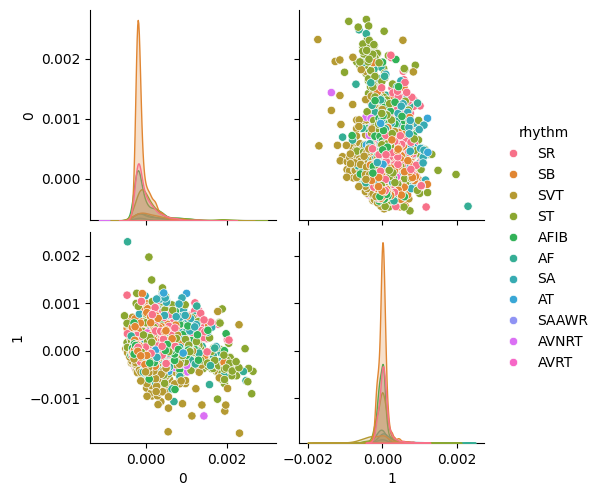

In [94]:
sns.pairplot(pca_data[[0, 1, 'rhythm']], hue="rhythm")

In [95]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [96]:
predictions = neigh.predict(X_test)

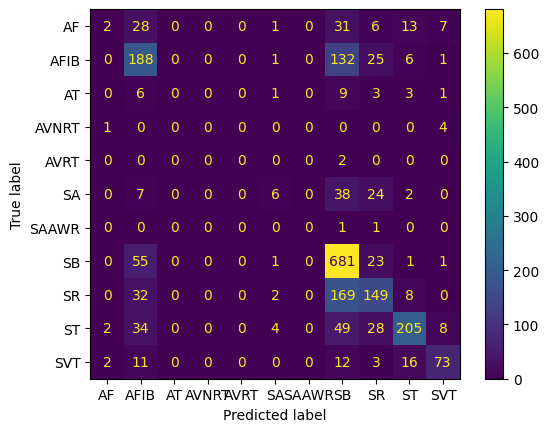

In [97]:
cm = confusion_matrix(y_test, predictions, labels=neigh.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot()
plt.show()

In [98]:
np.trace(cm) / np.sum(cm)

0.6153846153846154

### 3. Personalization

In [195]:
df, ld = Helper.load_embedding(path_evaluation, 'icentia11k', '9')

In [196]:
df.beat = df.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'PAC').replace(3.0, 'PVC')

In [197]:
tsne_data = Helper.embedding(df.iloc[:, 0:ld], df.iloc[:, ld:])

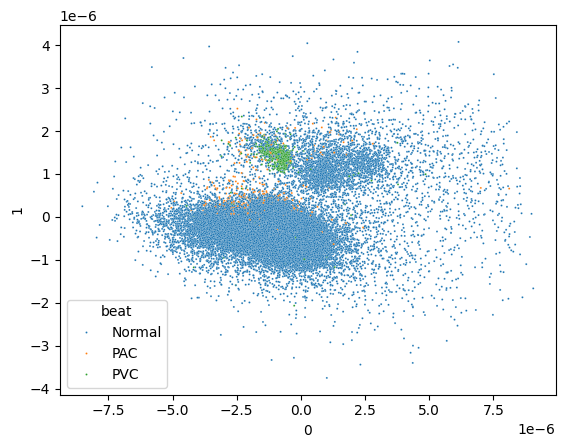

In [198]:
ax = sns.scatterplot(data=tsne_data[df.beat != 'Unclassified'], x=0, y=1, hue="beat", s=2)

In [199]:
X_train, X_test, y_train, y_test = train_test_split(
    df[df.beat != 'Unclassified'].iloc[:, 0:ld],
    df[df.beat != 'Unclassified']['beat'],
    test_size=0.2,
    random_state=42,
)

In [200]:
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(np.array(X_train), y_train)
predictions = neigh.predict(X_test)

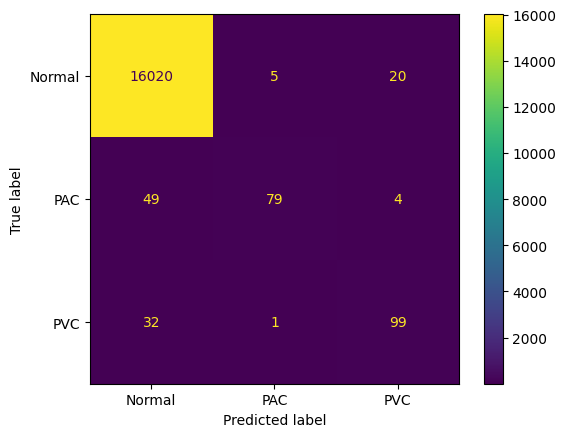

In [201]:
cm = confusion_matrix(y_test, predictions, labels=neigh.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot()
plt.show()

In [202]:
np.trace(cm) / np.sum(cm)

0.9931939419952174

In [203]:
cm

array([[16020,     5,    20],
       [   49,    79,     4],
       [   32,     1,    99]])

In [276]:
np.random.seed(42)

In [277]:
np.random.choice(range(100), 10, replace=False)

array([83, 53, 70, 45, 44, 39, 22, 80, 10,  0])

In [216]:
np.random.choice(range(10), 100)

array([2, 1, 0, 2, 0, 3, 8, 9, 2, 5, 7, 3, 1, 6, 1, 1, 5, 8, 4, 0, 1, 4,
       0, 1, 8, 5, 2, 8, 7, 2, 9, 1, 4, 0, 8, 5, 8, 2, 5, 6, 5, 7, 0, 7,
       0, 6, 9, 3, 8, 1, 2, 9, 9, 1, 4, 0, 5, 6, 4, 5, 0, 5, 0, 6, 5, 3,
       9, 6, 3, 2, 0, 7, 4, 2, 6, 4, 4, 8, 9, 5, 8, 9, 8, 9, 1, 3, 3, 9,
       6, 1, 9, 9, 8, 3, 4, 9, 9, 0, 8, 7])

In [218]:
path = '/mnt/sdb/icentia11k-single-lead-continuous-raw-electrocardiogram-dataset-1.0/'

In [288]:
np.random.seed(42)
np.random.choice(range(11000), 100, replace=False)

array([  107,  5484,  6998,  3984,  3111,  4040,  3013,  6607,  4219,
        8750,  5665,  9225,  8030,  9886,  1851,  1123,  3043,  3369,
        6829, 10969,  3088,  9405,  9535,  4993,  4209, 10937,  6167,
        4688,  6877, 10733,  8412, 10146, 10973,  9345,  2514,  2908,
        5938,  5015,  9595,  8769,  4786,  2602,  7779,  2826,  1118,
        3485,  2980, 10503,  7719,  6575,  1722,  7234,  8366,  3948,
        5493, 10731,  8111,  2820,  5337,  5369,  4184,  9403,  9625,
         303,    33,  3274,  1941,  9116,  9283,  3522,  4836,  7107,
         251,  9071,  6899,  9733,  9440,   457,  2954,  1839,  5865,
        8500,  9559,  1277,  1145, 10107,  9287,  8443,  9783,  9956,
       10090,  3204,  6814,  4553,  6377,  5572,  1178,  5032,  1793,
        4453])

In [225]:
segment = 0

In [226]:
t = segment // 1000

In [228]:
t

0

In [238]:
path + 'p' + f"{subject :02d}" + '/p' + f"{subject :05d}" + '/p' + f"{subject :05d}" + '_s' + f"{segment :02d}"

'/mnt/sdb/icentia11k-single-lead-continuous-raw-electrocardiogram-dataset-1.0/p1854/p01854/p01854_s00'

In [255]:
formatted_str = f'{subject:002d}'

# Take the last two characters to get a string with two decimals in total
formatted_str

'1854'

In [264]:
subject = 10854

In [265]:
t = subject // 1000

In [266]:
path + 'p' + f"{t :02d}"

'/mnt/sdb/icentia11k-single-lead-continuous-raw-electrocardiogram-dataset-1.0/p10'

In [242]:
result_str

'18'

In [245]:
def format_integer(num):
    # Convert the integer to a string with leading zeros and two decimal places
    formatted_str = f'{num:02.0f}'
    
    # Take the last two characters to get a string with two decimals in total
    result_str = formatted_str[-2:]
    
    return result_str

# Examples
print(format_integer(1854))  # Output: '01'
print(format_integer(185))   # Output: '00'
print(format_integer(9851))  # Output: '09'
print(format_integer(10345)) # Output: '10'

54
85
51
45


In [234]:
str(subject)[0:1]

'1'

In [ ]:
p01854